In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Loading and preparing the data

In [2]:
relative_path = 'datasets/diamonds/diamonds.csv'

In [3]:
data = pd.read_csv(relative_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float64
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float64
 5   table    5000 non-null   float64
 6   price    5000 non-null   int64  
 7   x        5000 non-null   float64
 8   y        5000 non-null   float64
 9   z        5000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 390.8+ KB


In [4]:
num_cols = [
    'carat',
    'depth',
    'table',
    'x',
    'y',
    'z'
]
cat_cols = [
    'cut',
    'color',
    'clarity',
]
target_col = ['price']

In [5]:
data = data[(data[num_cols + target_col] > 0).all(axis=1)]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=target_col),
    data[target_col],
    test_size=0.3,
    random_state=42
)

### Training Catboost regressor

In [7]:
from catboost import CatBoostRegressor, Pool

In [8]:
train_pool = Pool(
    X_train, y_train, 
    cat_features=cat_cols
)

test_pool = Pool(
    X_test, y_test, 
    cat_features=cat_cols
)

A Catboost model trained with default parameters is a great start and in most cases has great performance out of the box

In [9]:
catboost = CatBoostRegressor(verbose=200)
catboost.fit(train_pool)

Learning rate set to 0.049887
0:	learn: 3819.1224547	total: 155ms	remaining: 2m 34s
200:	learn: 659.5986201	total: 4.63s	remaining: 18.4s
400:	learn: 550.8684713	total: 9.3s	remaining: 13.9s
600:	learn: 479.0214584	total: 13.9s	remaining: 9.23s
800:	learn: 422.5433524	total: 18.4s	remaining: 4.58s
999:	learn: 387.0756883	total: 23s	remaining: 0us


In [13]:
y_pred = pd.Series(catboost.predict(X_test), name='predicted price')
pd.concat([y_test.reset_index(drop=True), y_pred], axis=1)

,price,predicted price
0,900,780.980136
1,5851,5569.986054
2,1316,1373.000404
3,11452,10641.624697
4,7127,7075.787871
...,...,...
1492,18493,16599.417184
1493,2825,2910.031473
1494,12971,12635.829440
1495,4103,3680.816460


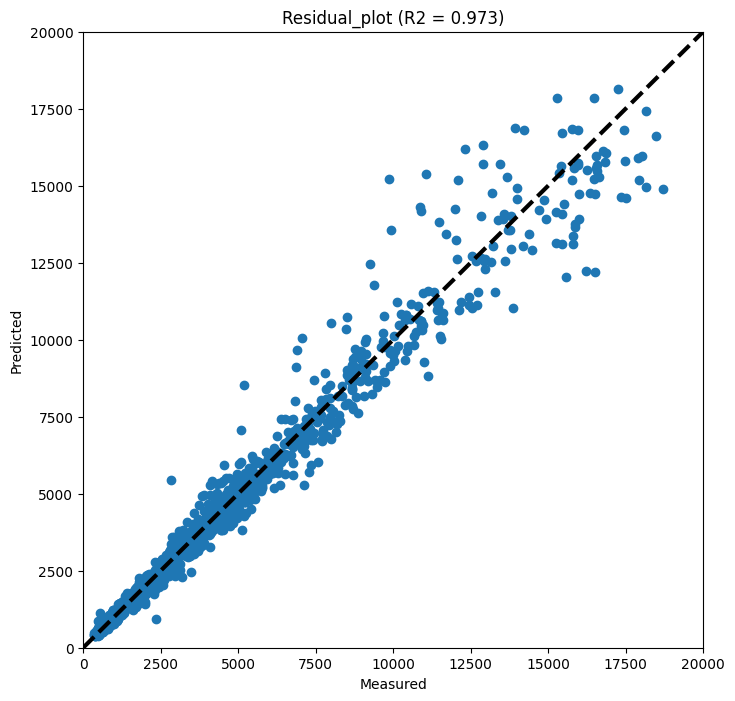

In [22]:
def residual_plot(target, prediction, score=None, marks=1):
    
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (8, 8)

    if score:
        ax.set_title(f'Residual_plot (R2 = {score.round(3)})')

    ax.plot(target, prediction, "o", markevery=marks)
    ax.plot([0, 20000], [0, 20000], 'k--', lw=3)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_ylim(bottom=0, top=20000)
    ax.set_xlim(left=0, right=20000)

    plt.show()
    
residual_plot(
    y_test.to_numpy(),
    catboost.predict(X_test),
    catboost.score(test_pool)
)

### Looking at feature importance

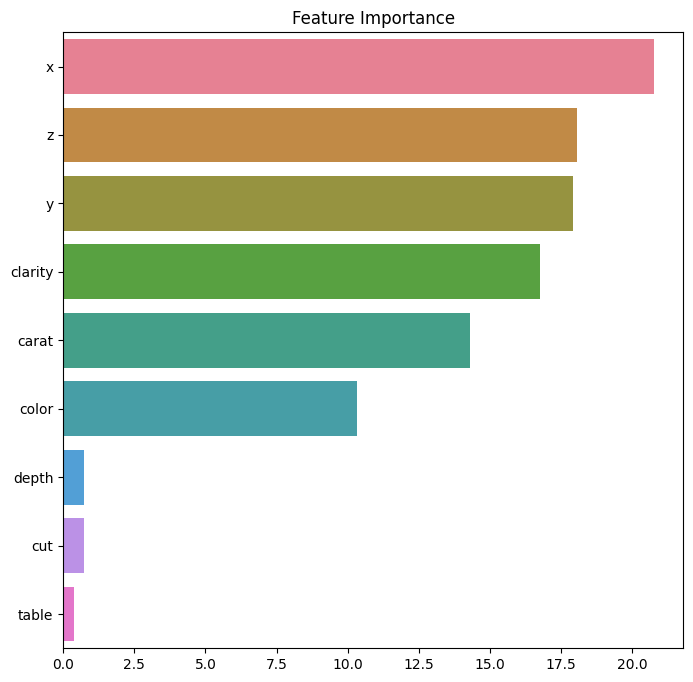

In [16]:
def plot_catboost_fi(model, X):
    CAT_FI = model.get_feature_importance()
    feat_dict = {}
    for col, val in sorted(zip(X.columns, CAT_FI),
                        key=lambda x: x[1], reverse=True):
        feat_dict[col] = val

    feat_df = pd.DataFrame(
        {'Feature': feat_dict.keys(), 'Importance': feat_dict.values()})[:25]
    values = feat_df.Importance
    idx = feat_df.Feature
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.barplot(y=idx, x=values, palette='husl')
    ax.set(title='Feature Importance')
    ax.set(xlabel='', ylabel='')
    plt.show()
    
plot_catboost_fi(catboost, X_test) 

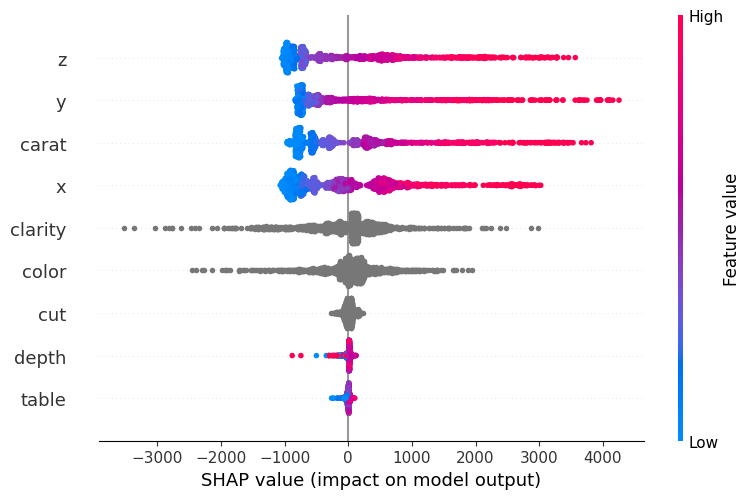

In [ ]:
import shap

explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_test)

ax = shap.summary_plot(shap_values, X_test, plot_type="dot")

Looks like the dimensions are the most importantfeatures, while depth, cut and table have the least influence on the model predictions

### Optional model tuning with cross-validation

In [18]:
grid = {'learning_rate': [0.03, 0.05, 0.08],
        'depth': [4, 6, 8], 
        'l2_leaf_reg': [1, 3, 5],
        }

model_cv = CatBoostRegressor(
    cat_features=cat_cols,
    task_type='GPU',
    verbose=500
)

grid_search_result = model_cv.grid_search(
    grid,
    train_pool,
    cv=3,
    partition_random_seed=42,
    train_size=0.8,
    verbose=False,
    plot=False
)

0:	learn: 5214.2458023	test: 5105.8987503	best: 5105.8987503 (0)	total: 58.6ms	remaining: 58.5s
500:	learn: 512.5558208	test: 674.2730818	best: 674.2730818 (500)	total: 24.4s	remaining: 24.3s
999:	learn: 480.0906944	test: 664.1992221	best: 664.1171967 (990)	total: 49.1s	remaining: 0us
bestTest = 664.1171967
bestIteration = 990
Training on fold [0/3]
0:	learn: 5129.5220734	test: 5334.2164492	best: 5334.2164492 (0)	total: 54.1ms	remaining: 54.1s
500:	learn: 559.1212054	test: 690.7705345	best: 690.7705345 (500)	total: 22.9s	remaining: 22.8s
999:	learn: 487.3180972	test: 655.0420044	best: 654.9963406 (998)	total: 45.8s	remaining: 0us
bestTest = 654.9963406
bestIteration = 998
Training on fold [1/3]
0:	learn: 5257.5462585	test: 5070.3590091	best: 5070.3590091 (0)	total: 55.1ms	remaining: 55s
500:	learn: 539.0696835	test: 712.5627337	best: 712.4380289 (491)	total: 24.3s	remaining: 24.2s
999:	learn: 488.6318370	test: 693.1869526	best: 691.1389673 (968)	total: 49.3s	remaining: 0us
bestTest = 6